# A study on Normality tests on Interferometer data containing glitches  
Here, I will be studying different statistical tests for normality to see how they function and whether they would be a good fit for whitened GW time-series signals containing glitches.

The hypotheses here are as follows

H0: The given signal is non-gaussian
H1: The given signal is non non-gaussian (Not necessarily a gaussian but could be any other type of distribution)

A lot of these tests treat data as points in a distribution as independent points that are not associated with one another, i.e. there is no consideration of the temporal component that time series data is inherently based on. So a lot of these tests may not be the best way to be assessing our data but it would still be helpful to go through them all the same.

Some of the tests I will be looking at are:

- The Shapiro-Wilk test
- The Kolmogorov-Smirnov test
- The Anderson-Darling test
- The Cramer-von Mises Criterion
- Kullback-Liebler divergence

I am also interested in exploring cumulant analysis, but that has a lower priority.

The solution I am looking for here is that some the test I come up with should have the least amount of false positives while also suiting the data we are working with.

# The gaussian distribution

Below is how a normal distribution would look

![Normal Distribution](images/normal_distribution.png)

With the following formula

$$
f(x) = \frac{1}{\sqrt{2\pi \sigma^2}}e^{-\frac{(x - \mu)^2}{2\sigma^2}}
$$

where $\mu$ is the distribution mean and $\sigma^2$ is the variance.

The example of a gaussian we have in our case is the white noise we will be injecting our glitch into to study its properties.

I will now be loading up the packages we need for this project along with the glitch archetype that we plan on studying. 

In [7]:
import pycbc
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
from scipy import stats
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
from matplotlib.ticker import ScalarFormatter

sns.set()

# Loading the data
Now, I have been provided a dataset with glitch information from the O3 runs of all the interferometers. Here I will be focusing on Tomte glitches from the LIGO interferometer to study how these statistical tests would help give us an idea whether we are able to differentiate between a glitch and its surrounding white/gaussian noise.

In [2]:
glitches = pd.read_csv('./data/O3a_allifo.csv')

Here's a breakdown of the CSV data

- **GPStime**: The timestamp in GPS format indicating the event time.
- **peakFreq**: The frequency at which the signal has the highest intensity.
- **snr**: Signal-to-noise ratio, indicating the clarity of the signal.
- **amplitude**: The strength or height of the signal wave.
- **centralFreq**: The central frequency of the signal's spectral content.
- **duration**: The time span of the signal event.
- **bandwidth**: The range of frequencies covered by the signal.
- **chisq**: The chi-squared statistic for assessing signal fit quality.
- **chisqDof**: The degrees of freedom used in the chi-squared test.
- **confidence**: The likelihood or certainty of the detection.
- **id**: A unique identifier for the signal event.
- **ifo**: The interferometer associated with the signal detection.
- **label**: Classification or annotation of the event.
- **imgUrl**: Link to an image or visual representation of the signal.
- **Q-value**: Quality factor indicating the sharpness of the signal.

In [3]:
tomte_glitches = glitches[(glitches['label'] == 'Tomte') & (glitches['ifo'] == 'L1')]
tomte_glitches.shape

(20804, 15)

# Exploring Tomte Glitches

The code below will give us a visualization on how long each of the tomte glitches are.

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_21598/1624218367.py:3: SyntaxWarning: invalid escape sequence '\m'
  label=f'$\mu=$'+str(np.round(np.mean(tomte_glitches['duration'].values), 3))+' s')


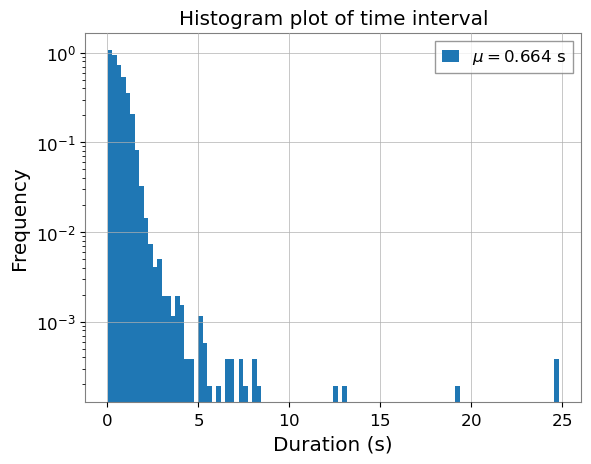

In [4]:
np.round(np.mean(tomte_glitches['duration'].values), 2)
plt.hist(tomte_glitches['duration'].values, bins=100, density=True,
         label=f'$\mu=$'+str(np.round(np.mean(tomte_glitches['duration'].values), 3))+' s')
plt.yscale('log')
plt.xlabel('Duration (s)')
plt.ylabel('Frequency')
plt.title('Histogram plot of time interval')
plt.legend()

I will now be loading up the dataset from `gwpy` using the TimeSeries package.

In [5]:
def get_noise_data(selected, srate=4096, tw=3, ifo='L1', begin=0, end=50):
    data_readings = []
    g_stars = selected['GPStime'].iloc[begin:end]

    # fetching the timeseries data according to GPStime
    for g_star in g_stars:
        # Fetching the data with the time window around the glitch
        noise = TimeSeries.fetch_open_data(ifo, g_star - tw ,  g_star + tw, sample_rate=srate)
        noise = noise.to_pycbc()

        # Whitening the noise signal
        whitened_noise, psd = noise.whiten(len(noise) / (2 * srate),
                                        len(noise)/( 4 * srate),
                                        remove_corrupted = False,
                                        return_psd = True)
        
        
        
        # Crop 1s at each side to avoid border effects.
        whitened_noise = whitened_noise[int(srate * 1):-int(srate * 1)]

        # We then convert this data from pycbc to a TimeSeries object
        # and fetch the q-scan of it
        data = TimeSeries(whitened_noise, sample_rate = srate)
        q_scan = data.q_transform(qrange=[4,64], frange=[10, 2048],
                                tres=0.002, fres=0.5, whiten=False)
        
        # t = data.times[int(srate * 1.5):-int(srate * 1.5)]
        # y = data.value[int(srate * 1.5):-int(srate * 1.5)]
        data_readings.append((g_star,data,q_scan))
        # noise_readings.append(whitened_noise)

    data_df = pd.DataFrame(data_readings, columns=['GPStime', 'data', 'q_transform'])
    return data_df

In previous testing, I had come across an anomalous glitch that failed the Shapiro Wilks test between rows 100 to 150 of the dataset. So I will, for the most part, be refering to this data

In [6]:
# The default tw here is 3 which will, in the end,
# gives us 2 seconds of time around the glitch  
data_df = get_noise_data(tomte_glitches, begin=100, end=150)

/home/ashishmathew0297/miniconda3/envs/gengli_env/lib/python3.12/site-packages/gwpy/signal/qtransform.py:124: UserWarning: upper frequency of 2048.00 is too high for the given Q range, resetting to 1291.05
  warnings.warn('upper frequency of %.2f is too high for the given '
/home/ashishmathew0297/miniconda3/envs/gengli_env/lib/python3.12/site-packages/gwpy/signal/qtransform.py:124: UserWarning: upper frequency of 2048.00 is too high for the given Q range, resetting to 1291.05
  warnings.warn('upper frequency of %.2f is too high for the given '


# Studying our data

Let's look at some of the data we have loaded up to see how it looks. We will be looking at it both as a weveform from the IFO and also as a normal distribution since both are bring studied in the upcoming sections.

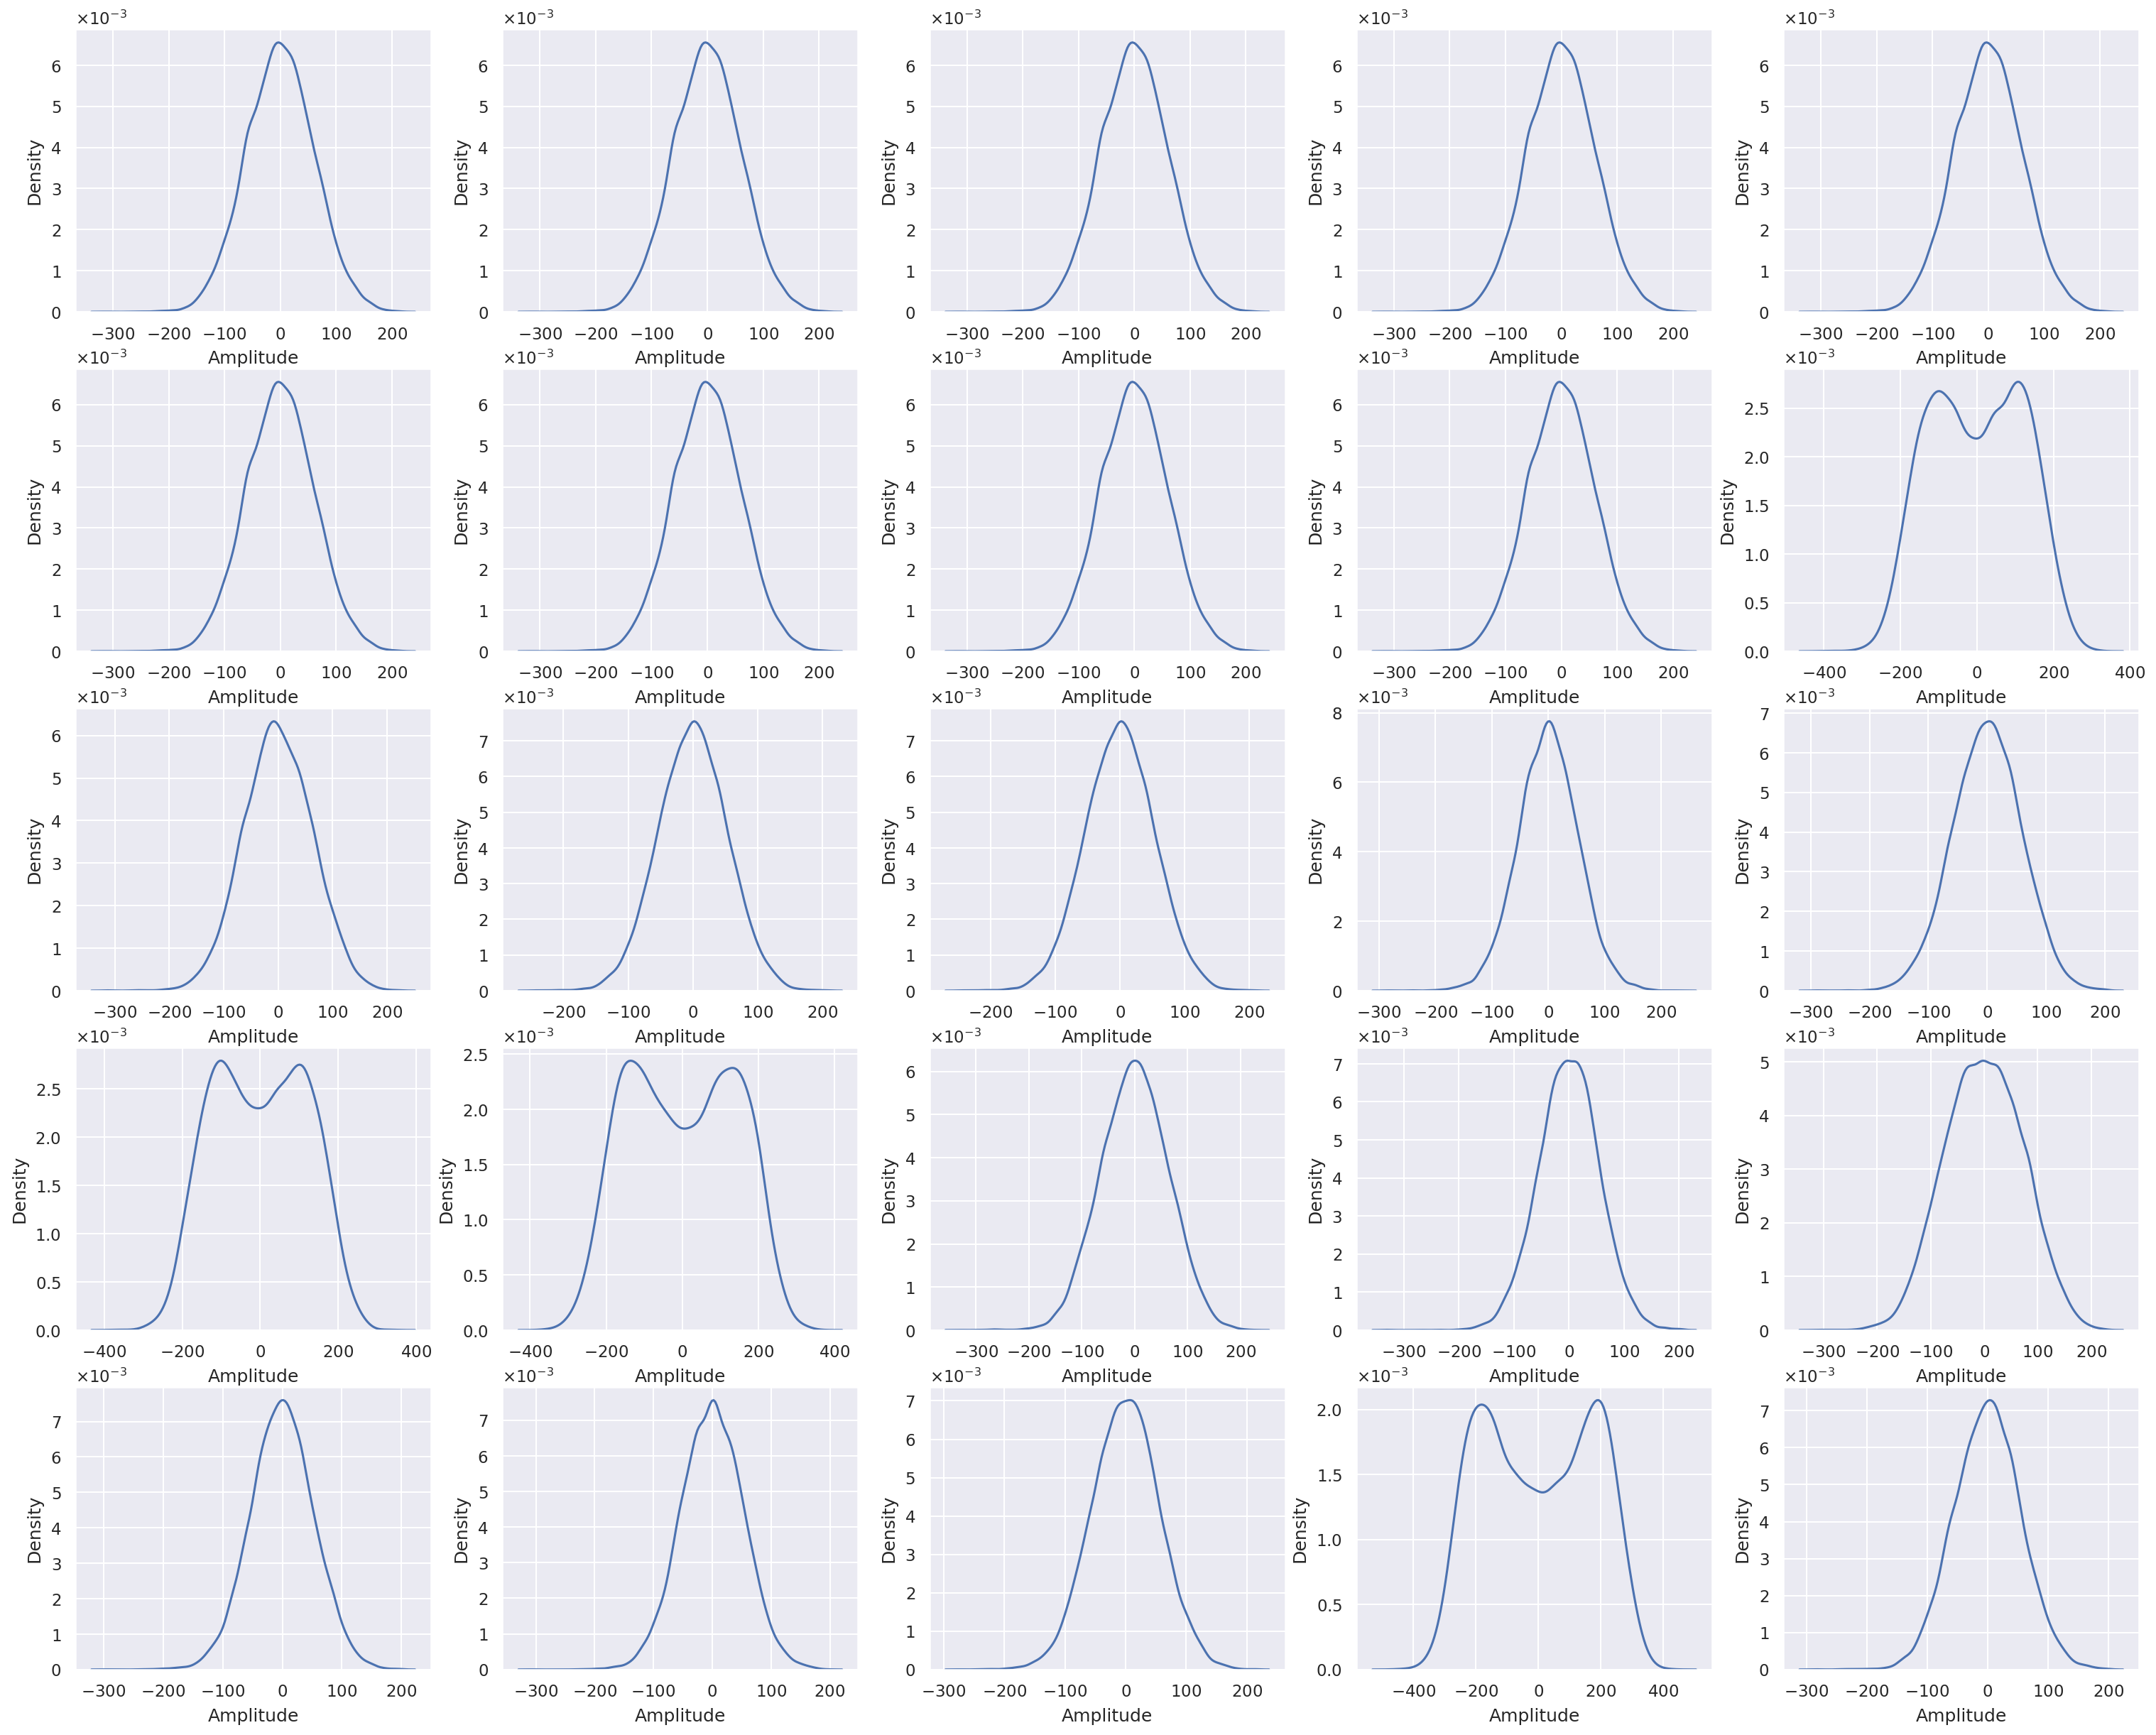

In [21]:
fig, axes = plt.subplots(5,5, figsize=(25,20), dpi=150)

# Looping through the axes
for idx, ax in enumerate(list(itertools.chain.from_iterable(axes))):
    sns.kdeplot(ax=ax, data=data_df['data'].iloc[idx].value)
    ax.set_xlabel('Amplitude')

plt.show()


# The Shapiro Wilk Test

The null hypothesis of this test is that our data comes from a normal distribution. This test only works for univariate, continuous data.

Given a sample $x_{1} \dots x_{n}$, with $n$ as the number of data points the Shapiro-Wilks test statistic is given by $W$ as follows

$$
W = \frac{(\sum_{i=1}^{n}a_{i}x_{(i)})^2}{\sum_{i=1}^{n}(x_i - \bar{x})^2}
$$

If a distribution is normal then, $(\sum_{i=1}^{n}a_{i}x_{(i)})^2$ should be an estimate of the population's variance $\sigma^2$

The denominator here is also an estimation of population variance $\sigma^2$

So, for the null hypothesis here to hold absolutely true: $W=1$; since the numerator and denominator are both estimating the variance.

In our case with the glitched infused data, if the W statistic here lies close 

For values less than one, it indicates a non-normal distribution

### Issues with this test

- It won't work well if our data has too many equal values
- For a small dataset, our null hypothesis will rarely get rejected
- For a large dataset, our null hypothesis will be rejected for tiny differences from normality

A large p value doesn't prove that a distribution is normal, but that it is not significantly difference from a normal distribution.

### Note

Shapiro Wilks test is too sensitive - a histogram/Q-Q plot should be used when assessing it if we face issues due to this.

### About "a"

Taking the numerator

$$(\sum_{i=1}^{n}a_{i}x_{(i)})^2$$

Here, $x_{(i)}$ are the ["order statistics"](https://youtu.be/gDtkGqLD1R0), that is, the values obtained from the sample when sorted in ascending order.

$a_i$ are constants given by

$$
\frac{m^TV^{-1}}{||V^{-1}m||}
$$

Here, $m$ represents a vector of order statistics we would expect from a standard normal distribution.

$V$ is the covariance matrix given by

$$
V = \mu[X_i - \mu X_i][X_j - \mu X_j]
$$

where $\mu$ is the expected mean of the distribution.

So, for example, if we had two points, $a$ would be $[0.5]$, for 3 points, $[0.375, 0.625]$, for 4 points, $[0.2857, 0.5, 0.7143]$,  and so on.

## The issue with order statistics here

The data we are using has a temporal component to it. The Shapiro Wilk test requires rearrangement of the data points, hence rendering this temporal component useless to us. We can still investigate this but will only be able to treat the wave data objectively, like how we would a normal distribution.

### Q-Q plots

These plot quantiles of our data vs expected quantiles of a normal distribution.

This is a good alternative to checking the Shapiro p-value

(Quantile = fraction of points below a given value)
![q-q plot](ad_4nxcrzsncc66mesuuafrmu-n91-w2j72w29cr-sb_o5_9y4k4errnbl3ei0req8twyso1snfa3haoctju5kfnadqygfo0micewassf3ljzvx1thwjgoytvchzbxyqmqdsemaovm7beg.avif)

I will now apply the Shapiro Wilks test to the data and study it a bit to see how it fares.

In [13]:
data_df['shapiro_pvalue'] = data_df['y'].apply(lambda y: stats.shapiro(y).pvalue)
data_df['shapiro_statistic'] = data_df['y'].apply(lambda y: stats.shapiro(y).statistic)
# display_shapiro_stats(data_df_4096, 3)

NameError: name 'data_df' is not defined

In [ ]:
fig, ax = plt.subplots(1,2,sharex=True, dpi=150)
ax[0].hist(data_df['shapiro_pvalue'], bins=40)
ax[0].set_xlabel('Shapiro p-value')
ax[0].set_ylabel('Frequency')
# ax[0].set_xticks(list(np.arange(data_df['shapiro_pvalue'].min(), data_df['shapiro_pvalue'].max()+0.01, 0.01)), fontsize=8, rotation=90)
ax[0].set_title('Shapiro p-values')
ax[1].hist(data_df['shapiro_statistic'], bins=40)
ax[1].set_xlabel('Shapiro Statistic')
ax[1].set_ylabel('Frequency')
# ax[1].set_xticks(list(np.arange(data_df['shapiro_statistic'].min(), data_df['shapiro_pvalue'].max()+0.01, 0.01)), fontsize=8, rotation=90)
ax[1].set_title('Shapiro Statistic Values')
plt.show()
print(f"Number of Shapiro p-values above 0.05: {(data_df['shapiro_pvalue'] > 0.05).sum()}")
print(f"Max Shapiro p-value: {data_df['shapiro_pvalue'].max()}")
print(f"Min Shapiro p-value: {data_df['shapiro_pvalue'].min()}")